In [1]:
import hydra
import re
import pyrootutils
import os
import torch

from omegaconf import OmegaConf
import json
from typing import Optional
import transformers
from PIL import Image
from torchvision.transforms.functional import InterpolationMode

# pyrootutils.setup_root(__file__, indicator=".project-root", pythonpath=True)

BOI_TOKEN = '<img>'
EOI_TOKEN = '</img>'
IMG_TOKEN = '<img_{:05d}>'

sep = "\n"
user_token = "USER"
assistant_token = "ASSISTANT"

IMG_FLAG = '<image>'
NUM_IMG_TOKNES = 32
NUM_IMG_CODES = 8192
image_id_shift = 32000

def generate(tokenizer, input_tokens, generation_config, model):
    """Only for batch_size=1"""

    input_ids = tokenizer(input_tokens, add_special_tokens=False, return_tensors='pt').input_ids
    input_ids = input_ids.to(model.device)

    generate_ids = model.generate(
        input_ids=input_ids,
        generation_config=generation_config
    )
    generate_ids = generate_ids[0][input_ids.shape[1]:]
    
    return generate_ids

def replace_img_tags(input_text):
    img_pattern = re.compile(r'<img>(.*?)</img>', re.IGNORECASE)
    img_matches = img_pattern.findall(input_text)
    
    for i, match in enumerate(img_matches):
        replacement = f'<IMAGE>'
        input_text = input_text.replace(f'<img>{match}</img>', replacement)
    
    return input_text
    
# def decode_image_text(generate_ids, tokenizer, save_path=None):

#     boi_list = torch.where(generate_ids == tokenizer(BOI_TOKEN, add_special_tokens=False).input_ids[0])[0]
#     eoi_list = torch.where(generate_ids == tokenizer(EOI_TOKEN, add_special_tokens=False).input_ids[0])[0]

#     if len(boi_list) == 0 and len(eoi_list) == 0:
#         text_ids = generate_ids
#         texts = tokenizer.decode(text_ids, skip_special_tokens=True)
#         print(texts)

#     else:
#         # for boi_index, eoi_index in zip(boi_list, eoi_list):

#         boi_index = boi_list[0]
#         eoi_index = eoi_list[0]

#         text_ids = generate_ids[:boi_index]
#         if len(text_ids) != 0:
#             texts = tokenizer.decode(text_ids, skip_special_tokens=True)
#             print(texts)
            
#         image_ids = (generate_ids[boi_index+1:eoi_index] - image_id_shift).reshape(1,-1)

#         images = tokenizer.decode_image(image_ids)

#         images[0].save(save_path)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/saydalie/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/saydalie/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
import sys
sys.path.append("/lid/home/saydalie/multimodal_cot/SEED/")

from models.seed_llama_tokenizer import SeedLlamaTokenizer
from models.transforms import get_transform
from models.model_tools import get_pretrained_llama_causal_model

In [3]:
tokenizer = SeedLlamaTokenizer.from_pretrained(
    pretrained_model_name_or_path="AILab-CVC/seed-tokenizer-2",
    fp16=True,
    load_diffusion=True,
    encoder_url="https://huggingface.co/AILab-CVC/seed-tokenizer-2/resolve/main/seed_quantizer.pt",
    diffusion_path="stabilityai/stable-diffusion-2-1-unclip"
)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LlamaTokenizer'. 
The class this function is called from is 'SeedLlamaTokenizer'.
/home/saydalie/.local/lib/python3.10/site-packages/timm/models/hub.py:4: FutureWarning: Importing from timm.models.hub is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/saydalie/.local/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/saydalie/.local/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please 

start download seed model...
/home/saydalie/.cache/torch/hub/checkpoints/seed_quantizer.pt
missing keys:  511 unexpected keys: 146


Loading pipeline components...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:32<00:00,  3.65s/it]


In [4]:
transform = get_transform(
    type="clip",
    image_size=224,
    keep_ratio=False
)

In [6]:
device = "cuda"
model_name_or_path="/lid/home/saydalie/multimodal_cot/SEED/checkpoints/seed-llama-8b-sft-comm"
# model_name_or_path="/lid/home/saydalie/multimodal_cot/SEED/checkpoints/seed-llama-8b-sft"

model = get_pretrained_llama_causal_model(
    pretrained_model_name_or_path=model_name_or_path,
    torch_dtype="fp16",
    low_cpu_mem_usage=True
).eval().to(device)

Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:30<00:00, 10.09s/it]


### Generate

In [126]:
from transformers.generation.configuration_utils import GenerationConfig

generation_config = GenerationConfig(
    temperature=1.0,
    num_beams=1,
    max_new_tokens=512,
    top_p=0.5,
    do_sample=True
)

In [127]:
# prompt="""A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant first thinks about the reasoning process in the mind using image and text interleaved and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> image-text interleaved reasoning process here </think> <answer> answer here </answer>.
# {bos}{user_token}: {question}
# {assistant_token}:"""
# scene = "A white hostel with a large tree to its left and a gravel road in front of the wooden entrance."
# question = "Is the white thing behind the tree?"

# input_tokens = prompt.format(
#     bos=tokenizer.bos_token,
#     user_token=user_token,
#     assistant_token=assistant_token,
#     question=f"{scene} {question}"
# )

# print(input_tokens)

In [128]:
prompt="""{bos}{user_token}: I now describe a scene and ask a question about it. First, think about the reasoning process using an interleaved combination of images and text. You should generate an image when necessary to support reasoning, then describe insights from the image before proceeding with more text-based deductions. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process with images and text here </think> <answer> the final answer here </answer>.
{question}
{assistant_token}: <think>"""
scene = "A white hostel with a large tree to its left and a gravel road in front of the wooden entrance."
question = "Is the white thing behind the tree?"

input_tokens = prompt.format(
    bos=tokenizer.bos_token,
    user_token=user_token,
    assistant_token=assistant_token,
    question=f"{scene} {question}"
)

print(input_tokens)

<s>USER: I now describe a scene and ask a question about it. First, think about the reasoning process using an interleaved combination of images and text. You should generate an image when necessary to support reasoning, then describe insights from the image before proceeding with more text-based deductions. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process with images and text here </think> <answer> the final answer here </answer>.
A white hostel with a large tree to its left and a gravel road in front of the wooden entrance. Is the white thing behind the tree?
ASSISTANT: <think>


In [129]:
# question = "Can you generate step-by-step instructions with images about How to Make Domino's Cheesy Bread?"
# input_tokens = tokenizer.bos_token + user_token + " " + question + sep + assistant_token

In [130]:
generate_ids = generate(tokenizer, input_tokens, generation_config, model)
generate_ids.shape

torch.Size([87])

### Decode

In [131]:
# decode text
output_text = tokenizer.decode(generate_ids, skip_special_tokens=False)
output_text = replace_img_tags(output_text)
output_text

'<IMAGE> <think> Yes, the white thing is a house. </think> <IMAGE> </s><s>'

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 22.93it/s]


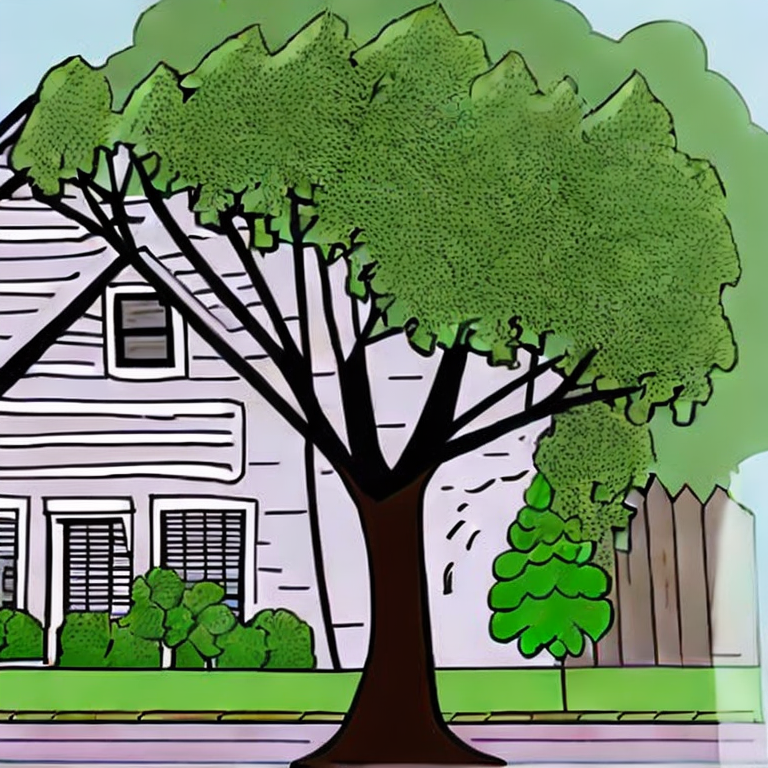

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 23.24it/s]


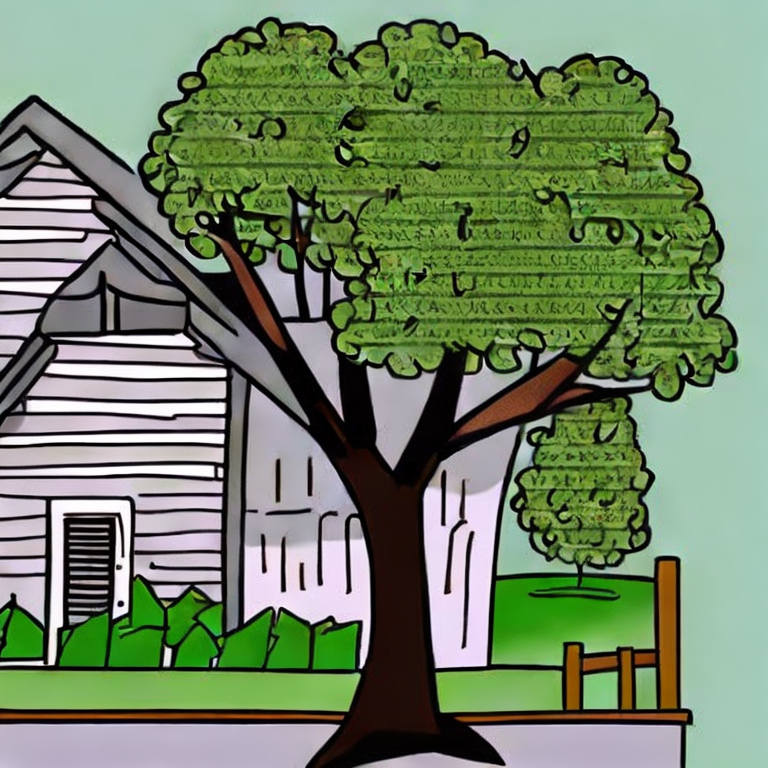

In [132]:
# decode images
boi_list = torch.where(generate_ids == tokenizer(BOI_TOKEN, add_special_tokens=False).input_ids[0])[0]
eoi_list = torch.where(generate_ids == tokenizer(EOI_TOKEN, add_special_tokens=False).input_ids[0])[0]

for boi_index, eoi_index in zip(boi_list, eoi_list):
    image_ids = (generate_ids[boi_index+1:eoi_index] - image_id_shift).reshape(1,-1)
    image = tokenizer.decode_image(image_ids)[0]
    image.show()